In [1]:
# import library for Support Vector Classification
from sklearn.svm import SVC

# import library for plot
import matplotlib.pyplot as plt

# import library for data handling
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math

# import library for pytorch
import torch
import torch.nn as nn

# import custom function
from stock_predict import SequenceDataset, ShallowRegressionLSTM, train, test, get_stock_data, split_train_test, predict, svc_train, svc_pred

# Get cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# predict df
predict_df = pd.DataFrame(columns = ["High", "Low", "Open", "Close"])

/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get the past stock price
df = get_stock_data(stock_name = 'TSLA', source = 'yahoo', past_year = 2)


In [3]:
pred_list = ["High", "Low", "Open", "Close"]

In [4]:
def run(df,training_target):

    # Split data into train and test
    train_df, test_df, feature, target, train_size, test_size, target_mean, target_std = split_train_test(training_target = training_target, df = df, train_ratio = 0.8)

    # create dataset and data loader
    batch_size = 4
    seq_len = 60

    torch.manual_seed(seq_len*batch_size/2)

    train_dataset = SequenceDataset(train_df, target, feature, seq_len)
    test_dataset = SequenceDataset(test_df, target, feature, seq_len)
    train_looader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # get the first batch and its shape
    x, y = next(iter(train_looader))
    print("Features shape: ", x.shape)
    print("Target shape: ", y.shape)

    # create model, loss and optimizer
    learning_rate = 5e-5
    num_hidden = 16
    epochs = 40

    model = ShallowRegressionLSTM(n_features = len(feature), n_hidden = num_hidden, device=device).to(device)
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # train and test model
    print("Untrained test\n----------------")
    test(model, test_loader, loss, device)
    print("\nTraining\n----------------")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n")
        train(model, train_looader, loss, optimizer, device)
        test(model, test_loader, loss, device)

    train_eval = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    prediction = f"{target}"
    train_df[prediction] = predict(train_eval, model, device)
    test_df[prediction] = predict(test_loader, model, device)

    df_out = pd.concat([train_df, test_df], axis=0)[[prediction]]

    for c in df_out.columns:
        df_out[c] = df_out[c] * target_std + target_mean
    
    return df_out


In [5]:
df_pred = pd.DataFrame()
for training_target in pred_list:
    print(f"Training target: {training_target}")
    df_out = run(df,training_target)
    df_pred = pd.concat([df_pred, df_out], axis=1)

Training target: High
Features shape:  torch.Size([4, 60, 5])
Target shape:  torch.Size([4])
Untrained test
----------------
Test loss: 0.3727

Training
----------------
Epoch 1

Train loss: 1.0055
Test loss: 0.3443
Epoch 2

Train loss: 0.9530
Test loss: 0.3172
Epoch 3

Train loss: 0.8965
Test loss: 0.2892
Epoch 4

Train loss: 0.8442
Test loss: 0.2615
Epoch 5

Train loss: 0.7879
Test loss: 0.2312
Epoch 6

Train loss: 0.7282
Test loss: 0.1982
Epoch 7

Train loss: 0.6660
Test loss: 0.1651
Epoch 8

Train loss: 0.5955
Test loss: 0.1307
Epoch 9

Train loss: 0.5293
Test loss: 0.0989
Epoch 10

Train loss: 0.4621
Test loss: 0.0715
Epoch 11

Train loss: 0.4025
Test loss: 0.0528
Epoch 12

Train loss: 0.3546
Test loss: 0.0416
Epoch 13

Train loss: 0.3188
Test loss: 0.0373
Epoch 14

Train loss: 0.2825
Test loss: 0.0379
Epoch 15

Train loss: 0.2551
Test loss: 0.0413
Epoch 16

Train loss: 0.2325
Test loss: 0.0464
Epoch 17

Train loss: 0.2126
Test loss: 0.0512
Epoch 18

Train loss: 0.1948
Test loss: 

In [6]:
df_pred[['High','Low','Open','Close']] = df_pred[['High_t+1','Low_t+1','Open_t+1','Close_t+1']].shift(-1)
df_pred['Close_actual'] = df['Close']

In [7]:
df_pred.drop(['High_t+1','Low_t+1','Open_t+1','Close_t+1'], axis=1, inplace=True)

In [8]:
df_pred = df_pred[:-1]

In [9]:
svc_model = svc_train(df)

In [10]:
df_pred

,High,Low,Open,Close,Close_actual
Date,,,,,
2020-09-17,172.877686,163.470825,168.445847,169.233612,141.143326
2020-09-18,176.010651,166.064255,171.380081,172.042953,147.383331
2020-09-21,176.285095,166.256729,171.222580,172.409027,149.796661
2020-09-22,174.955505,165.179886,170.237061,171.236603,141.410004
2020-09-23,174.359833,164.767883,169.738678,170.671539,126.786667
...,...,...,...,...,...
2022-09-08,299.438324,286.972717,292.545837,292.844543,289.260010
2022-09-09,305.260376,292.062988,298.217834,298.327637,299.679993
2022-09-12,306.426575,292.563232,299.038300,299.555023,304.420013


In [11]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-09-17,145.929993,136.000000,138.533340,141.143326,230337600.0,141.143326
2020-09-18,150.333328,142.933334,149.313339,147.383331,259220400.0,147.383331
2020-09-21,151.893326,135.690002,151.043335,149.796661,328430400.0,149.796661
2020-09-22,145.919998,139.199997,143.199997,141.410004,238742400.0,141.410004
2020-09-23,137.383331,125.293335,135.053329,126.786667,285222600.0,126.786667
...,...,...,...,...,...,...
2022-09-12,305.489990,300.399994,300.720001,304.420013,48674600.0,304.420013
2022-09-13,297.399994,290.399994,292.899994,292.130005,68229600.0,292.130005
2022-09-14,306.000000,291.640015,292.239990,302.609985,72628700.0,302.609985


In [21]:
type(svc_model)

sklearn.svm._classes.SVC

In [12]:
df_pred['action'] = svc_pred(df_pred, svc_model)

In [14]:
df['action'] = svc_pred(df,svc_model)

<AxesSubplot:xlabel='Date'>

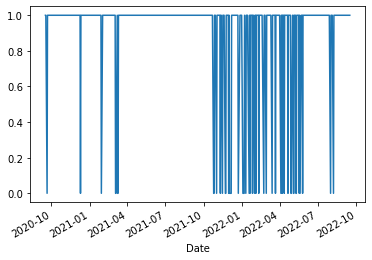

In [27]:
df['action'].plot()

In [24]:
df_pred['random'] = np.random.randint(0,2, len(df_pred))

# Calculate the daily returns from the stock
df_pred['returns'] = df_pred['Close'].pct_change(1)
df['returns'] = df['Close'].pct_change(1)

# Calculate the strategy returns
df['strategy_returns'] = df['action'].shift(1) * df['returns']

# Calculate the LSTM based strategy returns
df_pred['LSTM_returns'] = df_pred['action'].shift(1) * df_pred['returns']

# Calculate the random strategy returns
df_pred['random_returns'] = df_pred['random'].shift(1) * df_pred['returns']


# Calculate the cumulative strategy returns
df['cum_strategy_returns'] = (df['strategy_returns']).cumsum()

# Calculate the cumulative LSTM based strategy returns
df_pred['cum_LSTM_returns'] = (df_pred['LSTM_returns']).cumsum()

# Calculate the cumulative random returns
df_pred['cum_random_returns'] = (df_pred['random_returns']).cumsum()

# Calculate the cumulative stock returns
df['cum_stock_returns'] = (df['returns']).cumsum()


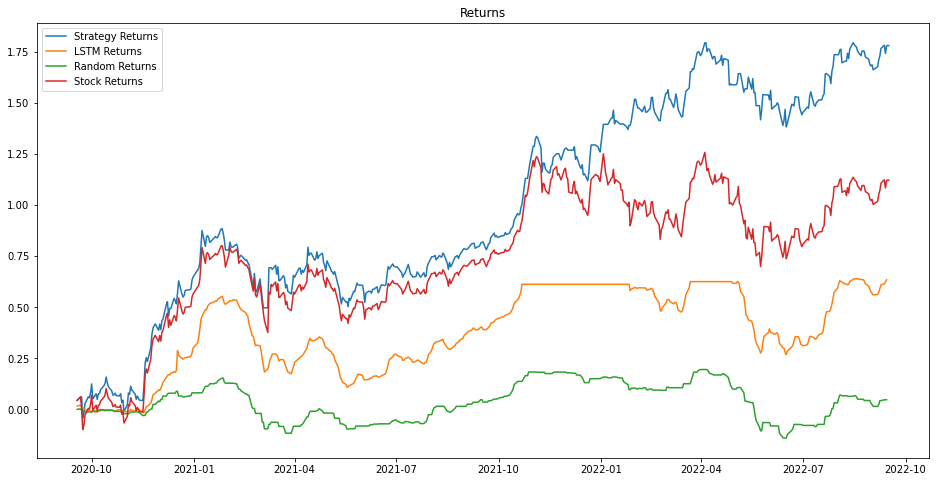

In [26]:
# plot the cumulative returns
plt.figure(figsize=(16,8))
plt.title('Returns')
plt.plot(df['cum_strategy_returns'], label='Strategy Returns')
plt.plot(df_pred['cum_LSTM_returns'], label='LSTM Returns')
plt.plot(df_pred['cum_random_returns'], label='Random Returns')
plt.plot(df['cum_stock_returns'], label='Stock Returns')
plt.legend()
plt.show()